# Berlin Airbnb Exploratory Data Analysis

In [482]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pathlib import Path
import re
from collections import Counter
from math import sin, cos, sqrt, atan2, radians

In [483]:
sns.set(style='whitegrid', palette='coolwarm')

## Project Brief

For this project we are interested in predicting the price a new airbnb user in Berlin should advertise their property for. We have 6 different tables that have been scraped from airbnb and put on kaggle. The 6 tables are:

- Calendar Summary
- Listings Summary
- Listings Detailed
- Neighbourhoods
- Reviews
- Reviews Detailed

As we are interested in predicting the price a new host should advertise their house for, the reviews data will most likely not be useful as this is retrospective data.

Firstly, I will explore the data sets and make notes of the data format and usefulness. Then I will clean the data to put in a useful format and perform some feature engineering to create useful information. Then I will attempt to create a model that accurately predicts the price of an airbnb in Berlin, given the property specifications.

In [484]:
# Read in all the tables
DATA_PATH = Path("../data/raw/")
calendar_summary = pd.read_csv(DATA_PATH/"calendar_summary.csv",parse_dates=["date"])
listings = pd.read_csv(DATA_PATH/"listings.csv", parse_dates=["last_review"])
listing_summary = pd.read_csv(
    DATA_PATH/"listings_summary.csv",
    parse_dates=[
        "last_scraped",
        "calendar_last_scraped",
        "last_review",
        "first_review",
        "host_since"
    ]
)
neighbourhoods = pd.read_csv(DATA_PATH/"neighbourhoods.csv")
reviews = pd.read_csv(DATA_PATH/"reviews.csv", parse_dates=["date"])
reviews_summary = pd.read_csv(DATA_PATH/"reviews_summary.csv", parse_dates=["date"])

# Describe the data

Calendar data for listings in Berlin

In [485]:
calendar_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8231480 entries, 0 to 8231479
Data columns (total 4 columns):
listing_id    int64
date          datetime64[ns]
available     object
price         object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 251.2+ MB


Listing summary information for Berlin

In [486]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 16 columns):
id                                22552 non-null int64
name                              22493 non-null object
host_id                           22552 non-null int64
host_name                         22526 non-null object
neighbourhood_group               22552 non-null object
neighbourhood                     22552 non-null object
latitude                          22552 non-null float64
longitude                         22552 non-null float64
room_type                         22552 non-null object
price                             22552 non-null int64
minimum_nights                    22552 non-null int64
number_of_reviews                 22552 non-null int64
last_review                       18644 non-null datetime64[ns]
reviews_per_month                 18638 non-null float64
calculated_host_listings_count    22552 non-null int64
availability_365                  22552 non-nu

More detailed listing information for Berlin

In [487]:
listing_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 96 columns):
id                                  22552 non-null int64
listing_url                         22552 non-null object
scrape_id                           22552 non-null int64
last_scraped                        22552 non-null datetime64[ns]
name                                22493 non-null object
summary                             21589 non-null object
space                               14020 non-null object
description                         22349 non-null object
experiences_offered                 22552 non-null object
neighborhood_overview               11540 non-null object
notes                               7215 non-null object
transit                             13036 non-null object
access                              10837 non-null object
interaction                         10406 non-null object
house_rules                         11449 non-null object
thumbnail_url   

In [488]:
listings_detailed = listing_summary
listings_summary = listings

Berlin neighbourhood data

In [489]:
neighbourhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 2 columns):
neighbourhood_group    138 non-null object
neighbourhood          138 non-null object
dtypes: object(2)
memory usage: 2.3+ KB


Summary reviews for listings in Berlin

In [490]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401963 entries, 0 to 401962
Data columns (total 2 columns):
listing_id    401963 non-null int64
date          401963 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.1 MB


Detailed reviews information for listings in Berlin

In [491]:
reviews_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401963 entries, 0 to 401962
Data columns (total 6 columns):
listing_id       401963 non-null int64
id               401963 non-null int64
date             401963 non-null datetime64[ns]
reviewer_id      401963 non-null int64
reviewer_name    401963 non-null object
comments         401467 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 18.4+ MB


In [492]:
reviews_detailed = reviews_summary
reviews_summary = reviews

### calendar_summary exploration

In [493]:
# Check for null values
calendar_summary.isnull().sum()

listing_id          0
date                0
available           0
price         6430639
dtype: int64

In [494]:
print(
    "Null values when available column is 'f': " + 
    str(calendar_summary[calendar_summary["available"]=="f"].isnull().sum()['price'])
)
print(
    "Null values when available column is not 'f': " + 
    str(calendar_summary[calendar_summary["available"]!="f"].isnull().sum()['price'])
)

Null values when available column is 'f': 6430639
Null values when available column is not 'f': 0


Summary information for datetime

In [495]:
calendar_summary.describe(include='datetime').T

,count,unique,top,freq,first,last
date,8231480,367,2019-02-10,22552,2018-11-07,2019-11-08


Summary information for object

In [496]:
calendar_summary.describe(include='object').T

,count,unique,top,freq
available,8231480,2,f,6430639
price,1800841,684,$50.00,68088


Percentage of price column that has missing values

In [497]:
print(100 * calendar_summary['price'].isnull().sum() /  len(calendar_summary))

78.12251259797752


### listings exploration

First I will determine if the summary data contains anything the detailed data doesn't

In [498]:
set(listings_summary.columns) - set(listings_detailed.columns)

{'neighbourhood_group'}

In [499]:
listings_summary['neighbourhood_group'].describe()

count                        22552
unique                          12
top       Friedrichshain-Kreuzberg
freq                          5497
Name: neighbourhood_group, dtype: object

In [500]:
listings_detailed['neighbourhood_group_cleansed'].describe()

count                        22552
unique                          12
top       Friedrichshain-Kreuzberg
freq                          5497
Name: neighbourhood_group_cleansed, dtype: object

In [501]:
all(listings_summary['neighbourhood_group'] == listings_detailed['neighbourhood_group_cleansed'])

True

In [502]:
wanted_columns = set(listings_summary.columns) - {"neighbourhood_group"}
all(listing_summary[wanted_columns] == listings_detailed[wanted_columns])

True

listings_summary is a less detailed version with duplicate results so we can just use the detailed version

In [503]:
listings_df = listings_detailed
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

Percentage of missing values in each column with a missing value

In [504]:
100 * (listings_df.isnull().sum()[(listings_df.isnull().sum() > 0)] / len(listings_df)).sort_values(ascending=False)

medium_url                     100.000000
jurisdiction_names             100.000000
thumbnail_url                  100.000000
host_acceptance_rate           100.000000
xl_picture_url                 100.000000
square_feet                     98.022348
license                         92.736786
monthly_price                   88.209471
weekly_price                    83.677723
notes                           68.007272
host_response_rate              57.178964
host_response_time              57.174530
interaction                     53.857751
access                          51.946612
host_about                      50.385775
house_rules                     49.232884
neighborhood_overview           48.829372
transit                         42.195814
security_deposit                41.508514
space                           37.832565
cleaning_fee                    31.686768
host_neighbourhood              22.587797
review_scores_value             19.665662
review_scores_checkin           19

Summary of the numerical data

In [505]:
listings_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,22552.0,1.571560e+07,8.552069e+06,2.015000e+03,8.065954e+06,1.686638e+07,2.258393e+07,2.986735e+07
scrape_id,22552.0,2.018111e+13,0.000000e+00,2.018111e+13,2.018111e+13,2.018111e+13,2.018111e+13,2.018111e+13
thumbnail_url,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
medium_url,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xl_picture_url,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_id,22552.0,5.403355e+07,5.816290e+07,2.217000e+03,9.240002e+06,3.126711e+07,8.067518e+07,2.245081e+08
host_acceptance_rate,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_listings_count,22526.0,2.330685e+00,1.994782e+01,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.676000e+03
host_total_listings_count,22526.0,2.330685e+00,1.994782e+01,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.676000e+03
latitude,22552.0,5.250982e+01,3.082546e-02,5.234580e+01,5.248906e+01,5.250908e+01,5.253267e+01,5.265167e+01


Summary of the object data

In [506]:
listings_df.describe(include='object').T

,count,unique,top,freq
listing_url,22552,22552,https://www.airbnb.com/rooms/9732185,1
name,22493,21873,Berlin Wohnung,14
summary,21589,21041,"with en-suite bathroom, TV, WIFI, bed linen, a...",14
space,14020,13598,The Singer 109 Hostel is located in the heart ...,41
description,22349,21997,We are located in one of the most colorful dis...,12
experiences_offered,22552,1,none,22552
neighborhood_overview,11540,10781,Welcome Traveler. The Singer Hostel and Apart...,43
notes,7215,6687,Since 01.01.2014 the city of Berlin had to ado...,37
transit,13036,12308,U-Bahn / Underground /Subway / Metro: U5 (Stra...,26
access,10837,9946,We can offer our guests - Pool table/Snooker -...,42


Summary information datetime information

In [507]:
listings_df.describe(include="datetime").T

,count,unique,top,freq,first,last
last_scraped,22552,2,2018-11-07,22549,2018-11-07,2018-11-09
host_since,22526,2914,2017-02-20,51,2008-08-18,2018-11-06
calendar_last_scraped,22552,2,2018-11-07,22549,2018-11-07,2018-11-09
first_review,18638,2228,2017-05-28,116,2009-06-20,2018-11-07
last_review,18644,1312,2018-11-04,618,2010-09-16,2018-11-07


Change t and f columns to boolean values and give summary

In [508]:
"""
boolean_conversion = {"t": True, "f": False}
boolean_columns = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "is_location_exact",
    "has_availability",
    "requires_license",
    "instant_bookable",
    "is_business_travel_ready",
    "require_guest_profile_picture",
    "require_guest_phone_verification"
]
for boolean_column in boolean_columns:
    listings_df[boolean_column] = listings_df[boolean_column].map(boolean_conversion)
"""

'\nboolean_conversion = {"t": True, "f": False}\nboolean_columns = [\n    "host_is_superhost",\n    "host_has_profile_pic",\n    "host_identity_verified",\n    "is_location_exact",\n    "has_availability",\n    "requires_license",\n    "instant_bookable",\n    "is_business_travel_ready",\n    "require_guest_profile_picture",\n    "require_guest_phone_verification"\n]\nfor boolean_column in boolean_columns:\n    listings_df[boolean_column] = listings_df[boolean_column].map(boolean_conversion)\n'

Analysing the distribution by neighbourhood

Text(0.5, 1.0, 'Distribution by Neighbourhood')

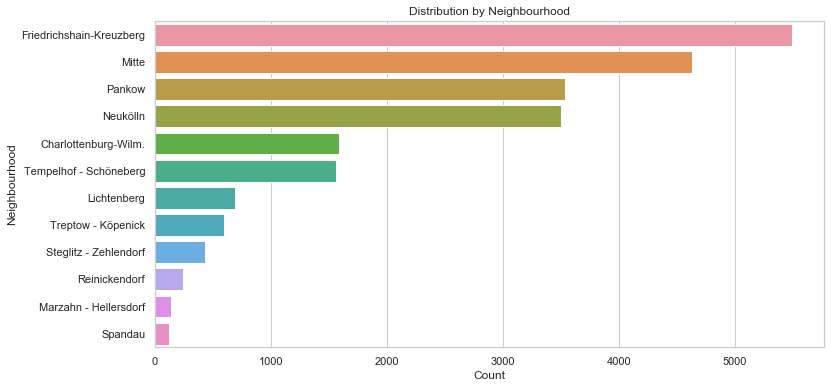

In [509]:
listings_by_neighbourhood = listings_df["neighbourhood_group_cleansed"].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=listings_by_neighbourhood.values,y=listings_by_neighbourhood.index)
plt.xlabel("Count")
plt.ylabel("Neighbourhood")
plt.title("Distribution by Neighbourhood")

Convert the price to a float

In [510]:
def price_string_to_float(price):
    """
    converts price string from string to float
    """
    return float(price.replace(",","").replace("$",""))

In [511]:
currency_columns = [
    'price',
    'weekly_price',
    'monthly_price',
    'security_deposit',
    'cleaning_fee',
    'extra_people'
]
for currency_column in currency_columns:
    listings_df[currency_column] = listings_df[currency_column].apply(lambda x: price_string_to_float(x) if pd.notnull(x) else x)

Analysing the distribution by room type

In [512]:
listings_df.groupby("room_type").describe().price

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,10722.0,83.348909,141.323687,0.0,49.0,65.0,91.0,9000.0
Private room,11534.0,52.479105,271.403759,0.0,25.0,35.0,45.0,8600.0
Shared room,296.0,51.564189,291.685951,8.0,18.0,25.0,38.0,5000.0


Text(0.5, 1.0, 'Distribution by Room Type')

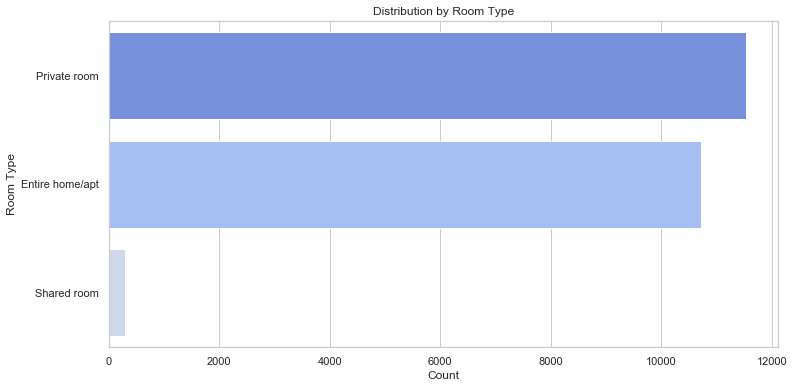

In [513]:
listings_by_room_type = listings_df["room_type"].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=listings_by_room_type.values,y=listings_by_room_type.index)
plt.xlabel("Count")
plt.ylabel("Room Type")
plt.title("Distribution by Room Type")

Set the index to be the listing id

In [514]:
listings_df = listings_df.set_index("id")

Checking the data for duplicates

In [515]:
all(~listings_df.duplicated())

True

Analysing the distribution of the price

Text(0.5, 1.0, 'Price Distribution')

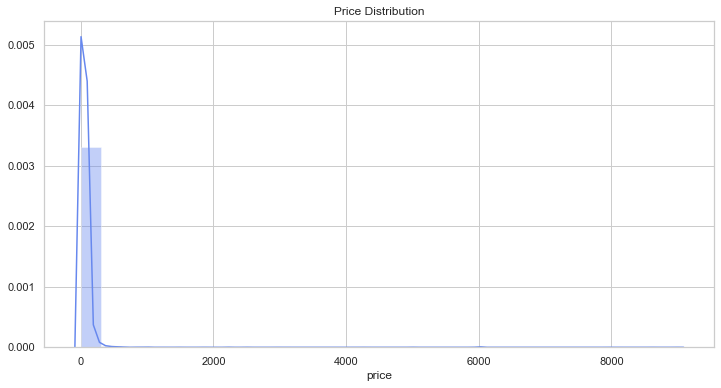

In [516]:
plt.figure(figsize=(12,6))
sns.distplot(listings_df["price"], bins=30)
plt.title("Price Distribution")

Exploring the distribution of accomodations by number of bedrooms

In [517]:
listings_by_bedroom_no = listings_df.groupby("bedrooms").describe()["price"]
listings_by_bedroom_no

,count,mean,std,min,25%,50%,75%,max
bedrooms,,,,,,,,
0.0,1477.0,55.974272,71.595328,10.0,35.00,50.0,65.00,2500.0
1.0,17164.0,57.933524,237.000776,0.0,30.00,40.0,60.00,9000.0
2.0,2973.0,93.670703,77.045447,0.0,55.00,80.0,110.00,1900.0
3.0,723.0,147.319502,163.514310,9.0,80.00,119.0,171.00,3000.0
4.0,143.0,175.692308,109.218945,22.0,100.00,150.0,220.00,650.0
5.0,34.0,571.941176,1377.128808,69.0,171.25,242.5,356.75,8000.0
6.0,10.0,262.200000,147.309048,70.0,152.25,257.0,360.00,500.0
7.0,3.0,346.333333,232.379718,79.0,269.50,460.0,480.00,500.0
8.0,4.0,408.000000,352.269783,74.0,220.25,329.5,517.25,899.0


Text(0, 0.5, 'Count')

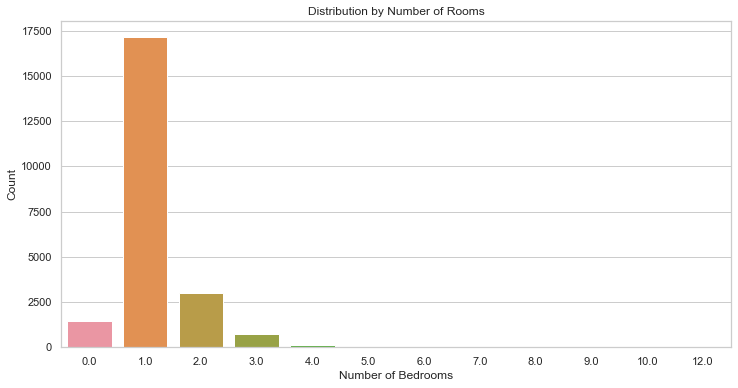

In [518]:
plt.figure(figsize=(12,6))
sns.barplot(x=listings_by_bedroom_no.index, y=listings_by_bedroom_no["count"])
plt.title("Distribution by Number of Rooms")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Count")

Analysing the host data

In [519]:
host_columns = [column for column in listings_df.columns if "host" in column]
listings_df[host_columns].isnull().sum()

host_id                               0
host_url                              0
host_name                            26
host_since                           26
host_location                       116
host_about                        11363
host_response_time                12894
host_response_rate                12895
host_acceptance_rate              22552
host_is_superhost                    26
host_thumbnail_url                   26
host_picture_url                     26
host_neighbourhood                 5094
host_listings_count                  26
host_total_listings_count            26
host_verifications                    0
host_has_profile_pic                 26
host_identity_verified               26
calculated_host_listings_count        0
dtype: int64

## Neighbourhoods exploration

In [520]:
neighbourhoods.describe()

,neighbourhood_group,neighbourhood
count,138,138
unique,12,138
top,Treptow - Köpenick,Karow
freq,20,1


In [521]:
neighbourhoods.head()

,neighbourhood_group,neighbourhood
0,Charlottenburg-Wilm.,Barstraße
1,Charlottenburg-Wilm.,Charlottenburg Nord
2,Charlottenburg-Wilm.,Düsseldorfer Straße
3,Charlottenburg-Wilm.,Forst Grunewald
4,Charlottenburg-Wilm.,Grunewald


Barplot representing the number of neighbourhoods that constitute to a neighbourhood group

Text(0.5, 0, 'Neighbourhoods')

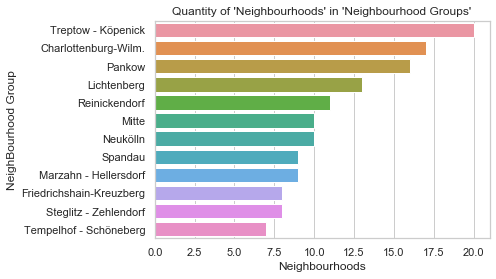

In [522]:
neighbourhood_groups_count = neighbourhoods["neighbourhood_group"].value_counts()
sns.barplot(x=neighbourhood_groups_count.values, y=neighbourhood_groups_count.index)
plt.title("Quantity of 'Neighbourhoods' in 'Neighbourhood Groups'")
plt.ylabel("NeighBourhood Group")
plt.xlabel("Neighbourhoods")

## Exploration Review

1. Calendar Summary

  - The only missing values are in the price column.
  - Price is only missing when available is 'f'.
  - The entries are from the period of 7/11/2018 to 8/11/2019
  - Could this be used to analyse how prices/availability fluctuate depending on time of year/day of the week?
  
  
2. Listings

  - There are five columns with entirely empty columns and many missing the majority of entries.
  - Nearly 20% of the listings dont have any review data.
  - There are a small amount of rows missing (seemingly) important information (beds, etc.).
  - All the hosts have been registered between 18/8/2008 and 6/11/2018.
  - There are 26 hosts that are missing most/all information about themselves.
  
  
3. Neighbourhoods

  - There are 12 neighbourhood groups that contain 138 neighbourhoods in total.
  
  
  
I will mostly use the listings data to create a model to predict the price. However, I will also attempt to use the calender data to model the change in price in different times of the year/days of the week.

## Data Cleaning

Remove columns that contain no information or zero variance

In [523]:
columns_to_remove = [
    "medium_url",
    "jurisdiction_names",
    "thumbnail_url",
    "host_acceptance_rate",
    "xl_picture_url",
    "experiences_offered",
    "country",
    "country_code",
    "has_availability",
    "is_business_travel_ready"
]
listings_df.drop(columns_to_remove, axis=1, inplace=True)

Remove descriptive columns

In [524]:
columns_to_remove = [
    "listing_url",
    "name",
    "summary",
    "space",
    "description",
    "neighborhood_overview",
    "notes",
    "transit",
    "access",
    "interaction",
    "house_rules",
    "picture_url",
    "host_url",
    "host_name",
    "host_location",
    "host_about",
    "host_response_rate",
    "host_thumbnail_url",
    "host_picture_url",
    "license"
]
listings_df.drop(columns_to_remove, axis=1, inplace=True)

Remove scrape data

In [525]:
listings_df.drop(['scrape_id', 'last_scraped'], axis=1, inplace=True)

Remove columns with a large amount of missing data

In [526]:
columns_to_remove = [
    "square_feet",
    "monthly_price",
    "weekly_price",
    "host_response_time",
    "security_deposit",
    "cleaning_fee",
    "host_neighbourhood",
    "first_review",
    "last_review"
]
listings_df.drop(columns_to_remove, axis=1, inplace=True)

Now I will get rid of a number of columns that a new host to airbnb wouldn't be able to provide or wouldn't be applicable

In [527]:
columns_to_remove = [
    "host_id",
    "host_since",
    "host_has_profile_pic",
    "calendar_updated",
    "calendar_last_scraped",
    "number_of_reviews",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
    "reviews_per_month"
]
listings_df.drop(columns_to_remove, axis=1, inplace=True)

In [528]:
listings_df.describe(include='object')

,host_is_superhost,host_verifications,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,...,is_location_exact,property_type,room_type,bed_type,amenities,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
count,22526,22552,22526,22552,21421,22552,22552,22547,22468,21896,...,22552,22552,22552,22552,22552,22552,22552,22552,22552,22552
unique,2,301,2,86,91,136,12,60,19,215,...,2,33,3,5,19985,2,2,5,2,2
top,f,"['email', 'phone', 'reviews']",f,"Berlin, Berlin, Germany",Neukölln,Tempelhofer Vorstadt,Friedrichshain-Kreuzberg,Berlin,Berlin,10245,...,t,Apartment,Private room,Real Bed,{},t,f,flexible,f,f
freq,19515,4103,13824,22317,3209,1325,5497,22417,22417,855,...,16776,20225,11534,21766,75,22544,15518,9102,22396,22273


Convert binary classification columns to boolean

In [529]:
bool_columns = [
    "is_location_exact",
    "requires_license",
    "instant_bookable",
    "require_guest_profile_picture",
    "require_guest_phone_verification"
]
for bool_column in bool_columns:
    listings_df[bool_column].map({"t": True, "f": False})

The distribution of price seems to be very skewed, so I will analyse the price including less results with a large price.

In [530]:
listings_df[listings_df["price"] > 500]["price"].count()

74

In [531]:
print((listings_df["price"] > 450).sum())
print((listings_df["price"] == 0).sum())

93
8


(0, 450)

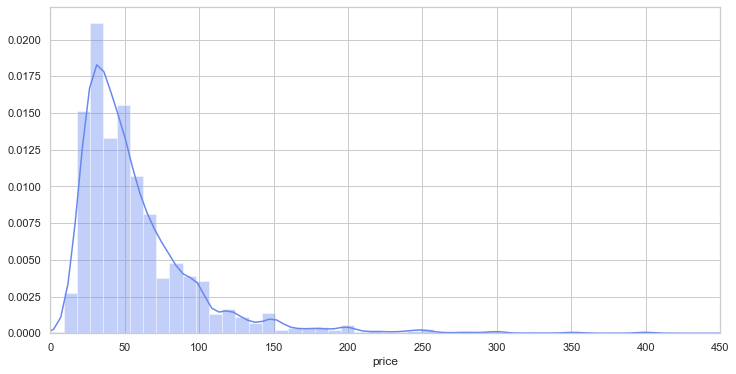

In [532]:
plt.figure(figsize=(12, 6))
sns.distplot(listings_df[listings_df["price"] < 450]["price"], bins=50)
plt.xlim((0, 450))

There seems to be a large amount of the data between 0 and 200, then some results scattered between 200 and 8000. It could be beneficial to the model to remove outliers to get a better prediction.

Looking at the correlations for price

In [533]:
listings_df.corr()["price"].sort_values()

longitude                        -0.042662
maximum_nights                   -0.000882
latitude                          0.002181
minimum_nights                    0.003626
host_listings_count               0.015221
host_total_listings_count         0.015221
extra_people                      0.018519
bathrooms                         0.067586
calculated_host_listings_count    0.073244
beds                              0.100805
guests_included                   0.102213
availability_365                  0.105959
availability_30                   0.110514
availability_90                   0.111024
bedrooms                          0.113095
availability_60                   0.114954
accommodates                      0.135563
price                             1.000000
Name: price, dtype: float64

From the correlations, I will get rid of more columns

In [534]:
columns_to_drop = [
    "maximum_nights",
    "minimum_nights",
    "host_listings_count",
    "host_total_listings_count",
    "extra_people",
    "availability_30",
    "availability_60",
    "availability_90"
]
listings_df.drop(columns_to_drop, axis=1, inplace=True)

We will just use the neighbourhood group for modelling so we can get rid of other locational details, aprt from lat, long as we can use this for feature engineering.

In [535]:
columns_to_drop = [
    "street",
    "neighbourhood",
    "neighbourhood_cleansed",
    "city",
    "state",
    "zipcode",
    "smart_location",
    "is_location_exact"
]
listings_df.drop(columns_to_drop, axis=1, inplace=True)

In [536]:
100 * (listings_df.isnull().sum()[(listings_df.isnull().sum() > 0)] / len(listings_df)).sort_values(ascending=False)

market                    0.279354
beds                      0.177368
bathrooms                 0.141894
host_identity_verified    0.115289
host_is_superhost         0.115289
bedrooms                  0.079816
dtype: float64

In [537]:
listings_df["market"].value_counts()

Berlin                   22483
Other (International)        2
Zurich                       1
Leipzig                      1
Juarez                       1
New York                     1
Name: market, dtype: int64

Upon inspection market seems to be not of any use and where the market is not Berlin the address is still in Berlin, so I will remove this column.

In [538]:
listings_df.drop("market", axis=1, inplace=True)

Looking at the correlation with beds to see how it can be filled

In [539]:
listings_df.corr()["beds"].sort_values(ascending=False)[1:]

accommodates                      0.790560
bedrooms                          0.613366
guests_included                   0.444461
bathrooms                         0.269561
calculated_host_listings_count    0.219973
availability_365                  0.192285
price                             0.100805
latitude                          0.013142
longitude                        -0.011911
Name: beds, dtype: float64

There is a high correlation with accomodates, so we could use this value to fill in the missing values

<Figure size 864x432 with 0 Axes>

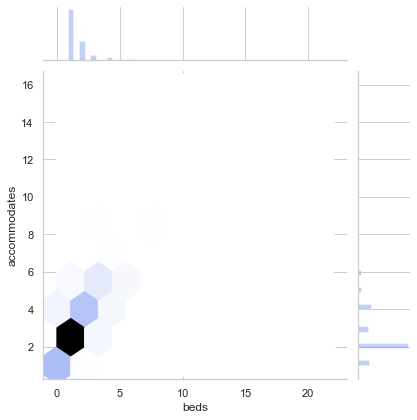

In [540]:
beds_accom_df = listings_df[["accommodates", "beds"]].dropna()
plt.figure(figsize=(12,6))
sns.jointplot(data=beds_accom_df, x="beds", y="accommodates", kind="hex", joint_kws={'gridsize':10})

Filling the missing beds values using the mean beds for each value of accomodates

In [541]:
beds_averages = beds_accom_df.groupby("accommodates").mean().to_numpy().flatten()
listings_df["beds"] = listings_df.apply(
    lambda row: beds_averages[row["accommodates"]-1] if np.isnan(row["beds"]) else row["beds"], axis=1
)

Dealing with the missing bedroom values

In [542]:
listings_df.corr()["bedrooms"].sort_values(ascending=False)[1:]

accommodates                      0.629575
beds                              0.613353
guests_included                   0.382306
bathrooms                         0.321342
price                             0.113095
availability_365                  0.075560
calculated_host_listings_count    0.043044
latitude                          0.009391
longitude                        -0.007163
Name: bedrooms, dtype: float64

We see that accommodates and bedrooms have a high correlation and so we can use this to estimate the number of bedrooms

In [543]:
bedrooms_accom_df = listings_df[["accommodates", "bedrooms"]].dropna()
bedrooms_averages = bedrooms_accom_df.groupby("accommodates").mean().to_numpy().flatten()
listings_df["bedrooms"] = listings_df.apply(
    lambda row: beds_averages[row["accommodates"]-1] if np.isnan(row["bedrooms"]) else row["bedrooms"], axis=1
)

Checking with columns still have null values

In [544]:
100 * (listings_df.isnull().sum()[(listings_df.isnull().sum() > 0)] / len(listings_df)).sort_values(ascending=False)

bathrooms                 0.141894
host_identity_verified    0.115289
host_is_superhost         0.115289
dtype: float64

In [545]:
print(listings_df["host_is_superhost"].value_counts())
print(listings_df["host_identity_verified"].value_counts())

f    19515
t     3011
Name: host_is_superhost, dtype: int64
f    13824
t     8702
Name: host_identity_verified, dtype: int64


We will fill in both the host_is_superhost and host_identity_verified missing values with the most common value for each column, which is false for both

In [546]:
host_null_columns = ["host_is_superhost", "host_identity_verified"]
listings_df[host_null_columns] = listings_df[host_null_columns].fillna("f")

Now convert the values to boolean

In [547]:
for host_column in host_null_columns:
    listings_df[host_column].map({'t': True, 'f': False})

Dealing with bathroom missing values

In [548]:
listings_df["bathrooms"].value_counts()

1.0    19807
2.0     1269
1.5     1146
0.5      104
2.5       74
3.0       50
0.0       41
4.0       12
3.5        3
8.5        3
7.0        3
7.5        2
5.0        2
8.0        2
4.5        1
6.0        1
Name: bathrooms, dtype: int64

Checking what kind of property the missing values are from

In [549]:
listings_df[listings_df["bathrooms"].isnull()]["property_type"].value_counts()

Apartment            30
Camper/RV             1
Bed and breakfast     1
Name: property_type, dtype: int64

Checking the correlations with bathrooms

In [550]:
listings_df.corr()["bathrooms"].sort_values(ascending=False)[1:]

bedrooms                          0.321199
beds                              0.269456
accommodates                      0.260085
guests_included                   0.177625
price                             0.067586
calculated_host_listings_count    0.044946
availability_365                  0.040982
latitude                         -0.002271
longitude                        -0.009384
Name: bathrooms, dtype: float64

In [551]:
listings_df[listings_df["bathrooms"].isnull()]["bedrooms"].value_counts()

1.0    28
2.0     4
Name: bedrooms, dtype: int64

In [552]:
listings_df.groupby("bedrooms").mean()["bathrooms"]

bedrooms
0.000000     1.020988
1.000000     1.063784
1.049890     1.166667
1.150303     1.000000
1.805231     1.000000
2.000000     1.146346
2.252491     1.000000
3.000000     1.444675
4.000000     1.835664
5.000000     2.176471
6.000000     2.800000
7.000000     4.500000
8.000000     3.500000
9.000000     3.000000
10.000000    2.000000
12.000000    7.000000
Name: bathrooms, dtype: float64

I think it is an adequate assumption that the missing values can be approximated as 1, which is by far the most common value. 

In [553]:
listings_df["bathrooms"] = listings_df["bathrooms"].fillna(1)

Checking if there is any other missing values

In [554]:
100 * (listings_df.isnull().sum()[(listings_df.isnull().sum() > 0)] / len(listings_df)).sort_values(ascending=False)

Series([], dtype: float64)

Now we have dealt with all our missing values we can further analyse our data

Feature engineer distance from landmarks/centre

In [555]:
def longlat_to_km(origin, destination):
    """
    Function that computes the distance between two (lat, long) points.
    """
    radius = 6371 # km
    lat1, long1 = origin
    lat2, long2 = destination
    
    dlat = radians(lat2 - lat1)
    dlong = radians(long2 - long1)
    
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlong / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = radius * c

    return distance

In [556]:
berlin_centre = (52.5200, 13.4050) # Coordinates found from google
listings_df["distance_from_centre"] = listings_df.apply(
    lambda listing: longlat_to_km((listing["latitude"], listing["longitude"]), berlin_centre), axis=1
)

Drop the latitude and longitude columns now we have computed the distance from the centre in km

In [557]:
listings_df.drop(["latitude", "longitude"], axis=1, inplace=True)

Describe the distance from centre 

In [558]:
listings_df["distance_from_centre"].describe()

count    22552.000000
mean         4.566539
std          2.751345
min          0.058689
25%          2.996943
50%          4.093354
75%          5.410169
max         25.674199
Name: distance_from_centre, dtype: float64

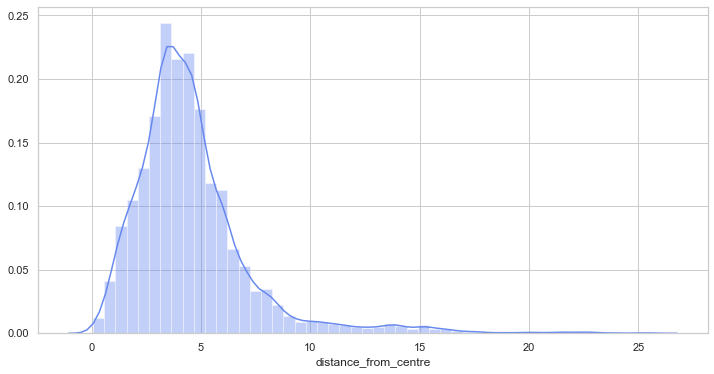

In [559]:
plt.figure(figsize=(12,6))
sns.distplot(listings_df["distance_from_centre"])

Looking at the correlation between distance from the centre and price

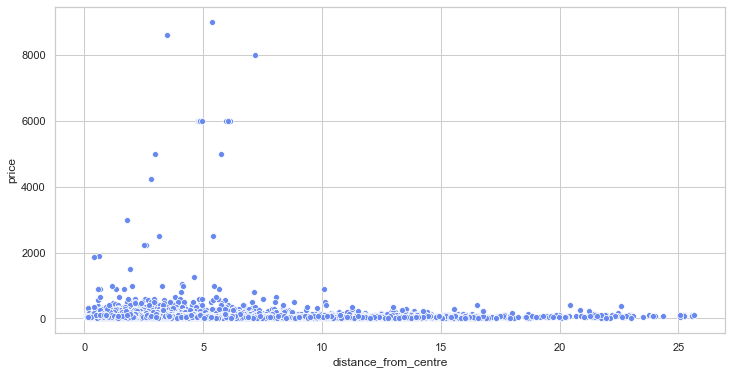

In [560]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=listings_df, x="distance_from_centre", y="price")

Analysing the host verifications column

In [561]:
listings_df["host_verifications"].describe()

count                             22552
unique                              301
top       ['email', 'phone', 'reviews']
freq                               4103
Name: host_verifications, dtype: object

Removing the host verifications column as looks to need a fair ammount of feature engineering

In [562]:
listings_df.drop("host_verifications", axis=1, inplace=True)

Analysing the host columns

In [563]:
listings_df[["host_identity_verified", "host_is_superhost"]].describe()

,host_identity_verified,host_is_superhost
count,22552,22552
unique,2,2
top,f,f
freq,13850,19541


Converting host columns to int

In [564]:
listings_df["host_identity_verified"] = listings_df["host_identity_verified"].map({'t': 1, 'f': 0})
listings_df["host_is_superhost"] = listings_df["host_is_superhost"].map({'t': 1, 'f': 0})

Analysing the property type

In [565]:
listings_df["property_type"].nunique()

33

In [566]:
listings_df.groupby("property_type").count()["price"].sort_values(ascending=False)

property_type
Apartment                 20225
Condominium                 612
Loft                        460
House                       398
Serviced apartment          175
Hostel                      128
Townhouse                    99
Guest suite                  74
Bed and breakfast            64
Guesthouse                   57
Hotel                        50
Other                        47
Boutique hotel               43
Bungalow                     20
Boat                         17
Tiny house                   12
Houseboat                    11
Camper/RV                    11
Villa                        10
Pension (South Korea)         7
Aparthotel                    7
Cabin                         6
Cottage                       4
Resort                        3
Castle                        2
Casa particular (Cuba)        2
Train                         2
Chalet                        1
Cave                          1
In-law                        1
Island                    

There are a lot of property types with very few listings, I think I should try combine related columns.

Thoughts:

- Combine House, Townhouse and Guest House.
- Combine Hotel and Boutique Hotel.
- Anything less than 50 occurances combine with other.

In [567]:
property_map = {
    'Townhouse': "House",
    'Guesthouse': "House",
    'Boutique hotel': "Hotel"
}
listings_df["property_type"] = listings_df["property_type"].apply(lambda x: property_map.get(x, x))

In [568]:
other_properties = (listings_df["property_type"].value_counts() < 50)
listings_df["property_type"] = listings_df["property_type"].apply(lambda x: "Other Property Type" if other_properties.loc[x] else x)

Describing the property type data

In [569]:
listings_df["property_type"].value_counts()

Apartment              20225
Condominium              612
House                    554
Loft                     460
Serviced apartment       175
Other Property Type      167
Hostel                   128
Hotel                     93
Guest suite               74
Bed and breakfast         64
Name: property_type, dtype: int64

Text(0.5, 0, 'Count')

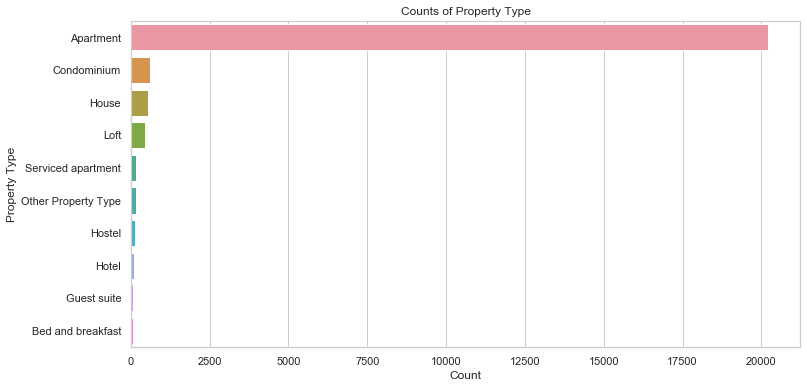

In [570]:
plt.figure(figsize=(12,6))
sns.barplot(x=listings_df["property_type"].value_counts().values, y=listings_df["property_type"].value_counts().index)
plt.title("Counts of Property Type")
plt.ylabel("Property Type")
plt.xlabel("Count")

Let's analyse the bed type column

In [571]:
listings_df["bed_type"].value_counts()

Real Bed         21766
Pull-out Sofa      451
Futon              240
Couch               72
Airbed              23
Name: bed_type, dtype: int64

We can transform into dummy variables later

Drop other columns I don't want to use

In [572]:
columns_to_drop = [
    "requires_license",
    "instant_bookable",
    "cancellation_policy",
    "require_guest_profile_picture",
    "require_guest_phone_verification"
]
listings_df.drop(columns_to_drop, axis=1, inplace=True)

In [573]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22552 entries, 2015 to 29867352
Data columns (total 16 columns):
host_is_superhost                 22552 non-null int64
host_identity_verified            22552 non-null int64
neighbourhood_group_cleansed      22552 non-null object
property_type                     22552 non-null object
room_type                         22552 non-null object
accommodates                      22552 non-null int64
bathrooms                         22552 non-null float64
bedrooms                          22552 non-null float64
beds                              22552 non-null float64
bed_type                          22552 non-null object
amenities                         22552 non-null object
price                             22552 non-null float64
guests_included                   22552 non-null int64
availability_365                  22552 non-null int64
calculated_host_listings_count    22552 non-null int64
distance_from_centre              22552 non-nul

Now let's look at the amenities column.
First lets remove unwanted characters from our amenities string.

In [574]:
def remove_characters(string, characters):
    """
    Function that removes all instances of characters from a string.
    Characters must be a string only containing the characters that should be removed.
    """
    translation_table = dict.fromkeys(map(ord, characters), None)
    clean_string = string.translate(translation_table)
    return clean_string

In [575]:
listings_df["amenities"] = listings_df["amenities"].apply(lambda x: set(remove_characters(x, '{}"').split(",")))

Creating a number of amenities column

In [576]:
listings_df["number_of_amenities"] = listings_df["amenities"].apply(lambda x: len(x))

Creating a counter object of the amenities

In [577]:
amenities_counter = Counter()
amenities_col_index = listings_df.columns.get_loc("amenities")
for listing in listings_df.values:
    amenities_counter.update(listing[amenities_col_index])

In [578]:
[(i, counter / len(listings_df) * 100) for i, counter in amenities_counter.most_common()]

[('Wifi', 95.38843561546648),
 ('Kitchen', 94.5902802412203),
 ('Heating', 93.96062433487053),
 ('Essentials', 90.1427811280596),
 ('Washer', 82.01933309684286),
 ('Hair dryer', 66.02962043277758),
 ('Laptop friendly workspace', 64.06083717630365),
 ('Hangers', 61.67080525008869),
 ('Iron', 49.689606243348706),
 ('Shampoo', 47.24192976232707),
 ('TV', 44.77651649521107),
 ('Hot water', 43.20681092586023),
 ('Family/kid friendly', 36.09879389854559),
 ('Internet', 35.07006030507272),
 ('Host greets you', 29.545051436679675),
 ('Smoke detector', 28.63160695282015),
 ('Buzzer/wireless intercom', 27.119545938275984),
 ('Lock on bedroom door', 23.474636395885064),
 ('Refrigerator', 23.111032280950692),
 ('Free street parking', 23.013479957431713),
 ('Dishes and silverware', 22.534586732884),
 ('Elevator', 21.581234480312165),
 ('Bed linens', 21.47037956722242),
 ('Cooking basics', 21.434905995033702),
 ('Stove', 21.35509045760908),
 ('Smoking allowed', 20.34852784675417),
 ('Oven', 19.12025

Creating variables from amenities and drop amenities column

In [579]:
amenities_to_include = [
    "Wifi",
    "Kitchen",
    "Heating",
    "Essentials",
    "Washer",
    "TV",
    "Dryer",
    "Dishwasher",
    "Bathtub",
    "Breakfast",
    "Wheelchair accessible",
    "Hot tub",
]
for amenity in amenities_to_include:
    listings_df[amenity] = listings_df["amenities"].apply(lambda x: 1 if amenity in x else 0)
listings_df.drop("amenities", axis=1, inplace=True)

Creating dummy variables from categorical columns

In [580]:
categorical_columns = [
    "neighbourhood_group_cleansed",
    "property_type",
    "room_type",
    "bed_type"
]
for categorical_column in categorical_columns:
    dummy_variables = pd.get_dummies(listings_df[categorical_column],drop_first=True)
    listings_df = pd.concat([listings_df.drop(categorical_column, axis=1), dummy_variables], axis=1)

Checking correlations between price and other columns

In [581]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22552 entries, 2015 to 29867352
Data columns (total 50 columns):
host_is_superhost                 22552 non-null int64
host_identity_verified            22552 non-null int64
accommodates                      22552 non-null int64
bathrooms                         22552 non-null float64
bedrooms                          22552 non-null float64
beds                              22552 non-null float64
price                             22552 non-null float64
guests_included                   22552 non-null int64
availability_365                  22552 non-null int64
calculated_host_listings_count    22552 non-null int64
distance_from_centre              22552 non-null float64
number_of_amenities               22552 non-null int64
Wifi                              22552 non-null int64
Kitchen                           22552 non-null int64
Heating                           22552 non-null int64
Essentials                        22552 non-null i

In [582]:
listings_df.corr()["price"].sort_values(ascending=False)[1:]

Hotel                             0.374493
accommodates                      0.135563
bedrooms                          0.113050
availability_365                  0.105959
guests_included                   0.102213
beds                              0.100646
TV                                0.084733
calculated_host_listings_count    0.073244
bathrooms                         0.067599
number_of_amenities               0.048295
Breakfast                         0.045697
Serviced apartment                0.043577
Dryer                             0.037420
Tempelhof - Schöneberg            0.036422
Loft                              0.034011
Bathtub                           0.031566
Hostel                            0.023946
Dishwasher                        0.021604
Real Bed                          0.012617
Other Property Type               0.011743
Wheelchair accessible             0.007842
Essentials                        0.007021
host_is_superhost                 0.006699
Mitte      